In [1]:
import networkx as nx
import numpy as np
import functools
import random

In [2]:
from optiLib.problem import NetGraph
from optiLib.problem import TaskGraph

def generate_adjacency_matrix(rows, cols):
    num_nodes = rows * cols
    adjacency_matrix = [[0 for _ in range(num_nodes)] for _ in range(num_nodes)]

    for row in range(rows):
        for col in range(cols):
            node_index = row * cols + col
            if col > 0:  # узел слева
                adjacency_matrix[node_index][node_index - 1] = 1
            if col < cols - 1:  # узел справа
                adjacency_matrix[node_index][node_index + 1] = 1
            if row > 0:  # узел сверху
                adjacency_matrix[node_index][node_index - cols] = 1
            if row < rows - 1:  # узел снизу
                adjacency_matrix[node_index][node_index + cols] = 1

    return adjacency_matrix


martx = [[0, 1500, 1500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 1500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 1500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 500, 500, 0, 500, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 100, 0, 0, 250, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 250, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 250, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 100, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 350, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 350, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 400, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 500],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],]

net  = NetGraph(generate_adjacency_matrix(7, 7), net_power=(1000, 2500), e0=(10, 50), emax=(70,100))
task = TaskGraph(martx, w=(100,600))

In [3]:
import functools
import networkx as nx
import numpy as np

@functools.lru_cache
def create_paths(vector, task_edges, network_graph):
    RANDOM_SEED = 1
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    paths = {}
    
    for start, end in task_edges:
        if vector[start] == vector[end]:
            paths[str(start) + str(end)] = [vector[start]]
        else:
            paths[str(start) + str(end)] = random.choice(list(nx.all_shortest_paths(network_graph, vector[start], vector[end])))
    return paths

@functools.lru_cache
def network_status_calculation(vector, problem):
    RANDOM_SEED = 1
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    
    T_lim = problem.t_lim
    vector_tuple = tuple(vector) 
    task_edges = tuple((start, end) for start, end, _ in nx.to_edgelist(problem.task_graph.graph))
    network_graph = problem.network_graph.graph
    
    paths = create_paths(vector_tuple, task_edges, network_graph)
    
    net_number = network_graph.number_of_nodes()
    task_number = problem.task_graph.graph.number_of_nodes()

    W = [0] * net_number
    v_task_to_node = [0] * net_number
    v_sent_to_node = [0] * net_number
    v_reseive_to_node = [0] * net_number
    
    for start, end, weight in nx.to_edgelist(problem.task_graph.graph):
        path_key = str(start) + str(end)
        path = paths[path_key]
        
        if len(path) > 1:
            W[path[0]] += problem.task_graph.operations[start].w + weight['weight']
            v_sent_to_node[path[0]] += weight['weight']
            v_task_to_node[path[0]] += problem.task_graph.operations[start].w
            
            W[path[-1]] += problem.task_graph.operations[end].w + weight['weight']
            v_reseive_to_node[path[-1]] += weight['weight']
            v_task_to_node[path[-1]] += problem.task_graph.operations[end].w
            
            for node in path[1:-1]:
                W[node] += 2 * weight['weight']
                v_sent_to_node[node] += weight['weight']
                v_reseive_to_node[node] += weight['weight']
        else:
            W[vector[start]] += problem.task_graph.operations[start].w
            v_task_to_node[vector[start]] += problem.task_graph.operations[start].w
            
            W[vector[end]] += problem.task_graph.operations[end].w
            v_task_to_node[vector[end]] += problem.task_graph.operations[end].w
    
    vector_tuple = tuple(vector) 
    
    arr = sorted(nx.all_simple_paths(problem.task_graph.graph, 0, task_number - 1), key=len, reverse=True)
    
    T_task = [0] * task_number
    len_first_path = len(arr[0])
    time_per_task = T_lim / len_first_path
    
    for task in arr[0]:
        T_task[task] = time_per_task
    
    for path_task in arr[1:]:
        sum_t = sum(T_task[task] for task in path_task)
        temp = [task for task in path_task if T_task[task] == 0]
        
        if temp:  # если нашлись задачи без оценки времени
            time_remaining = max(0, T_lim - sum_t)
            time_per_task_temp = time_remaining / len(temp)
            for task in temp:
                T_task[task] = time_per_task_temp
    
    T_NET = [0] * net_number

    for start, end, _ in nx.to_edgelist(problem.task_graph.graph):
        path_net = paths[str(start) + str(end)]
        if len(path_net) == 1:
            T_NET[path_net[-1]] = min(T_NET[path_net[-1]] or time_per_task, T_task[start], T_task[end])
        else:
            T_NET[path_net[-1]] = min(T_NET[path_net[-1]] or T_task[end], T_task[end])
            time_start_share = T_task[start] / (len(path_net) - 1)
            for node in path_net[:-1]:
                T_NET[node] = min(T_NET[node] or time_start_share, time_start_share)
    
    special_t = T_lim / len_first_path
    result = [[] for _ in range(net_number)]
    for i, val in enumerate(vector):
        result[val].append(i)
    
    for node in range(net_number):
        common_tasks = set(result[node]) & set(arr[0])
        if len(common_tasks) > 1:
            T_NET[node] = special_t * len(common_tasks)
    
    D = [W[i] / (problem.network_graph.nodes[i].p * T_NET[i]) if T_NET[i] != 0 else 0 for i in range(net_number)]
    return {"w":W, "v_task_to_node":v_task_to_node, "v_sent_to_node":v_sent_to_node, "v_reseive_to_node":v_reseive_to_node, "D":D, "T_NET":T_NET, "T_task":T_task}

def c1(vector, problem):
    net_ststus = network_status_calculation(tuple(vector), problem)
    D = net_ststus['D']
    flag = all(d <= 1 for d in D) 
    return int(flag)

def f1(vector, problem):
    """
    Функция которая на основе полученого времени работы и загружености расичтывает энергопотребление
    """
    net_ststus = network_status_calculation(tuple(vector), problem)
    D = net_ststus['D']
    T_NET = net_ststus['T_NET']

    T_lim = problem.t_lim
    net_number = problem.network_graph.graph.number_of_nodes()

    E = [0 for _ in range(net_number)]
    Z = [0 for _ in range(net_number)]
    for i in range(net_number):
        E[i] = problem.network_graph.nodes[i].e0 + (problem.network_graph.nodes[i].eMax - problem.network_graph.nodes[i].e0) * D[i]
        Z[i] = E[i]*T_NET[i] + (T_lim - T_NET[i])* problem.network_graph.nodes[i].e0
    Z = sum(Z)
    return Z

def f2(vector, problem):
    """
    Вычисляет количество пересылок данных, необходимых при распределении задач
    по узлам сети, если изначально все задачи были на узле 0.
    
    Args:
        vector (list): Вектор распределения задач на узлы сети.
        problem (): network_graph (nx.Graph): Граф сети.
        
    Returns:
        int: Общее количество пересылок данных.
    """
    total_transfers = 0
    network_graph = problem.network_graph.graph

    for task_id, node_id in enumerate(vector):
        if node_id != 0:
            # Найти кратчайший путь от узла 0 до текущего узла
            path = nx.shortest_path(network_graph, source=0, target=node_id)
            
            # Увеличить счетчик пересылок на количество узлов в пути
            total_transfers += len(path) - 1
    
    return total_transfers + 1


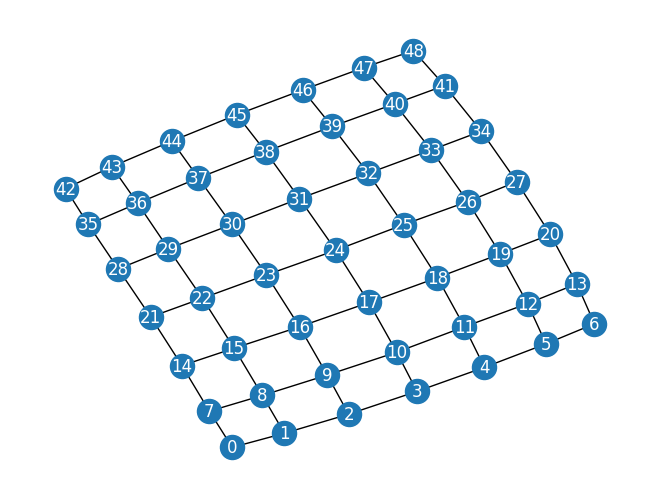

In [4]:
net.print()

In [5]:
print(net)

NetNode(p=200, e0=100, eMax=200)
NetNode(p=1620, e0=44, eMax=85)
NetNode(p=1805, e0=17, eMax=85)
NetNode(p=1913, e0=15, eMax=75)
NetNode(p=1763, e0=29, eMax=85)
NetNode(p=1711, e0=32, eMax=98)
NetNode(p=1336, e0=18, eMax=80)
NetNode(p=1685, e0=38, eMax=94)
NetNode(p=1828, e0=46, eMax=91)
NetNode(p=1384, e0=38, eMax=70)
NetNode(p=1935, e0=11, eMax=95)
NetNode(p=2302, e0=25, eMax=80)
NetNode(p=1335, e0=39, eMax=82)
NetNode(p=1058, e0=31, eMax=91)
NetNode(p=2486, e0=47, eMax=95)
NetNode(p=1092, e0=38, eMax=88)
NetNode(p=1996, e0=44, eMax=78)
NetNode(p=1004, e0=22, eMax=91)
NetNode(p=2065, e0=46, eMax=97)
NetNode(p=1333, e0=36, eMax=75)
NetNode(p=2144, e0=13, eMax=91)
NetNode(p=1405, e0=47, eMax=89)
NetNode(p=1301, e0=47, eMax=74)
NetNode(p=2037, e0=21, eMax=89)
NetNode(p=1745, e0=11, eMax=91)
NetNode(p=2499, e0=20, eMax=73)
NetNode(p=1048, e0=19, eMax=81)
NetNode(p=1534, e0=31, eMax=87)
NetNode(p=1544, e0=27, eMax=92)
NetNode(p=1471, e0=41, eMax=95)
NetNode(p=2281, e0=15, eMax=83)
NetNode

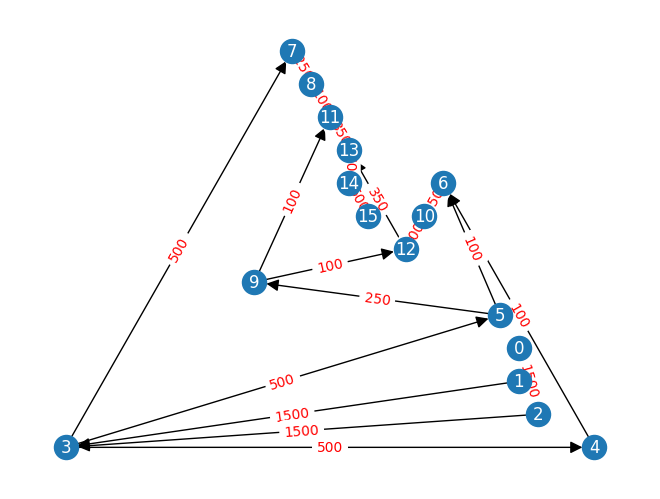

In [6]:
task.print()

In [7]:
print(task)

TaskNode(w=502)
TaskNode(w=596)
TaskNode(w=427)
TaskNode(w=132)
TaskNode(w=247)
TaskNode(w=459)
TaskNode(w=554)
TaskNode(w=120)
TaskNode(w=523)
TaskNode(w=149)
TaskNode(w=408)
TaskNode(w=244)
TaskNode(w=444)
TaskNode(w=335)
TaskNode(w=151)
TaskNode(w=233)


In [8]:
from optiLib import NetworkOptimizationProblem

problem = NetworkOptimizationProblem(net, task, f_objective=[f1,f2], f_constraints=[c1], t_lim=30)

In [9]:
RANDOM_SEED = 1
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

from optiLib.optimizers import RandomSearchOptimizer, ParticleSwarmOptimizer

# Инициализация оптимизатора
optimizer = ParticleSwarmOptimizer(problem, inertia = 0.7,cognitive = 1.5 , social = 1.5, num_particles=100, iterations=1000)

# Запуск оптимизации
best_solution, best_value = optimizer.optimize()

from optiLib.helpers import print_solution
print_solution(best_solution, best_value)

optimizer.save()

Optimizing: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


Лучшее решение: [14 15 15 15 15 15 14 14 14 15 15 15 15 14 15 14]
Значение целевой функции: 1948060.4895399585


In [10]:
RANDOM_SEED = 1
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

from optiLib.optimizers import RandomSearchOptimizer

# Инициализация оптимизатора
optimizer = RandomSearchOptimizer(problem,iterations = 100000)

# Запуск оптимизации
best_solution, best_value = optimizer.optimize()

from optiLib.helpers import print_solution
print_solution(best_solution, best_value)
optimizer.save()

Optimizing: 100%|██████████| 100000/100000 [00:06<00:00, 15843.94it/s]


Лучшее решение: [45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45]
Значение целевой функции: 6487057.416440831


In [11]:
RANDOM_SEED = 1
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

from optiLib.optimizers import GreedyOptimizer

# Инициализация оптимизатора
optimizer = GreedyOptimizer(problem)

# Запуск оптимизации
best_solution, best_value = optimizer.optimize()

from optiLib.helpers import print_solution
print_solution(best_solution, best_value)
optimizer.save()

Optimizing:   0%|          | 0/16 [00:00<?, ?it/s]


AttributeError: 'float' object has no attribute 'copy'